# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Первая лабораторная работа </center>


В данной работе Вы познакомитесь с основными методами работы с аудиоданными в Python. Разбересь в том, как работает свертка, и примените пару интересных фильтров.

# Задание 1. Работа с аудиофайлами в Python (1 балл)

## Теория

Звук - это аналоговый сигнал. То есть он является непрерывным по времени и по значениям. Для того, чтобы работать со звуком на цифровом устройстве, надо преобразовать его в цифровое представление. Для этого надо разделить непрерывный сигнал на промежутки времени (дискретизация сигнала) и разбить непрерывные значения на интервалы (квантование сигнала). Выбраные параметры дискретизации и квантования сигнала напрямую влияют на качество цифрового сигнала. 

<!-- 
## Практика

1. Что хранится в .wav файле? Как узнать параметры дискретизации и квантования .wav файла? 

2. Запишите аудиофайл со своим голосом. Загрузите его. Попробуйте поменять ему частоту дискретизации. Нарисуйте форму волны считанного файла. Воспроизведите полученные сигналы. При какой частоте дискретизации становится невозможно разобрать человеческую речь?   

3. Чем .wav отличается от других кодеков, например .mp3 или .ogg? -->


<!-- ### Подсказка

Записать цифровой сигнал можно при помощи, например, [Audacity](https://www.audacityteam.org) или [Adobe Audition](https://www.adobe.com/ru/products/audition.html). Для считывания файлов воспользуйтесь библиотекой [scipy](https://www.scipy.org) или [librosa](https://librosa.org/doc/latest/index.html). Для воспроизведения аудиофайла удобно использовать класс Audio из модуля IPython.display, а для отрисовки - matplotlib. -->

In [7]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy as sp
import soundfile as sf
import IPython.display as ipd


%matplotlib inline

### 1. Что хранится в .wav файле? Как узнать параметры дискретизации и квантования .wav файла?

### 2. Запишите аудиофайл со своим голосом. Загрузите его. Попробуйте поменять ему частоту дискретизации. Нарисуйте форму волны считанного файла. Воспроизведите полученные сигналы. При какой частоте дискретизации становится невозможно разобрать человеческую речь?

8 000 Гц — телефон, достаточно для речи, кодек Nellymoser;

11 025 Гц — четверть Audio CD, достаточно для передачи речи;

22 050 Гц — половина Audio CD, достаточно для передачи качества радио;

44 100 Гц — используется в Audio CD.

**Подсказка**

Записать цифровой сигнал можно при помощи, например, [Audacity](https://www.audacityteam.org) или [Adobe Audition](https://www.adobe.com/ru/products/audition.html). Для считывания файлов воспользуйтесь библиотекой [scipy](https://www.scipy.org) или [librosa](https://librosa.org/doc/latest/index.html). Для воспроизведения аудиофайла удобно использовать класс Audio из модуля IPython.display, а для отрисовки - matplotlib.

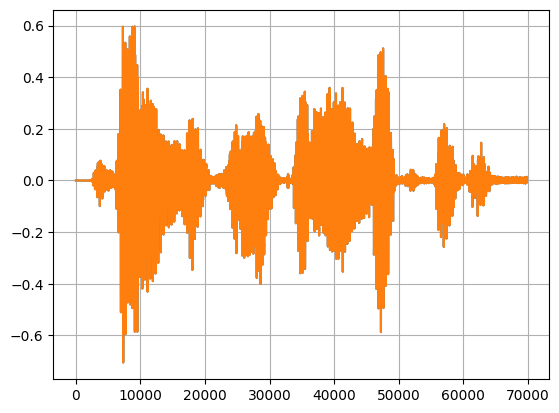

In [12]:
CD_SR = 44100

audio, sr = sf.read('resources/lab1_voice.wav')

if sr != CD_SR:
    raise Exception('Wrong Sample Rate.')

audio_f32 = audio.astype('float32')
plt.plot(np.arange(len(audio_f32)), audio_f32)
plt.grid()
ipd.display(ipd.Audio(audio_f32.T, rate=sr))

[None, None, None, None, None, None]

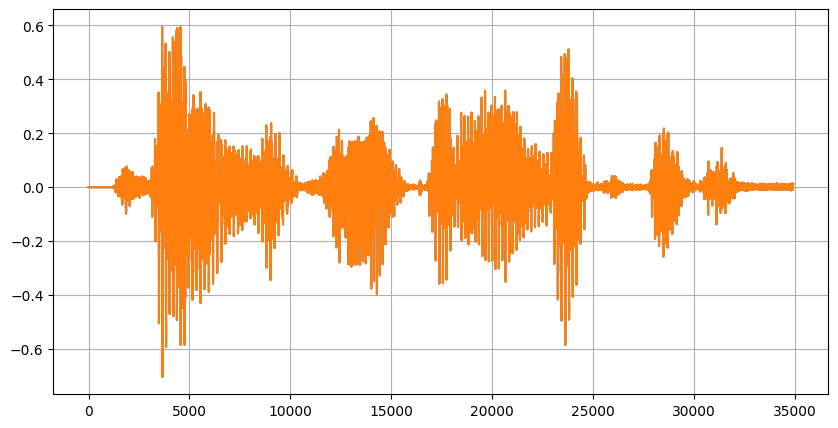

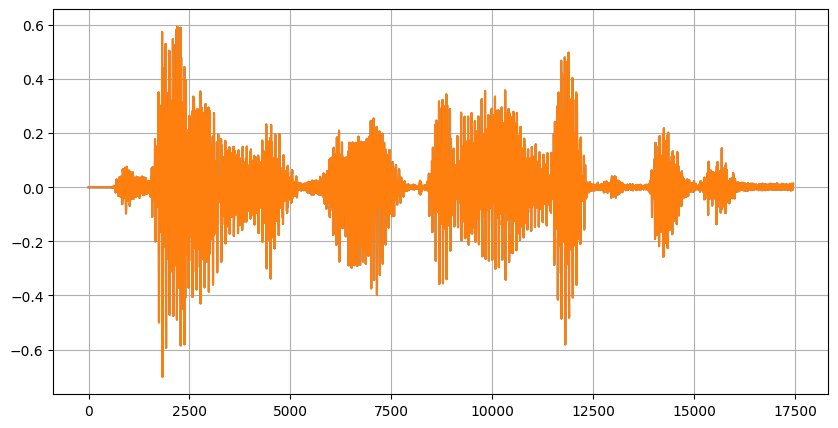

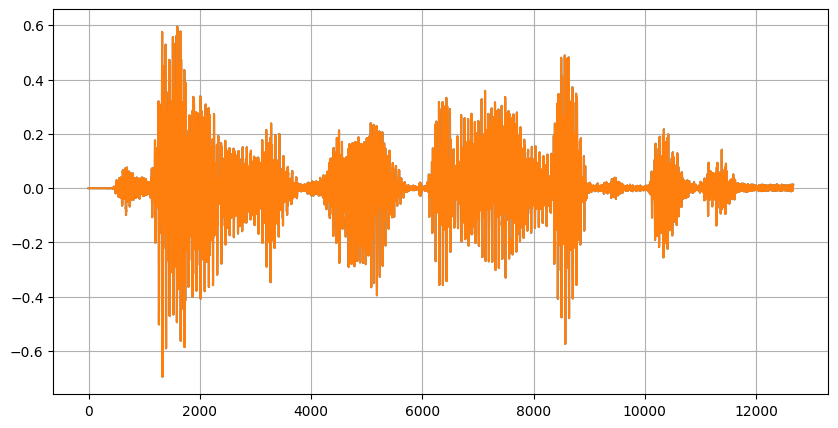

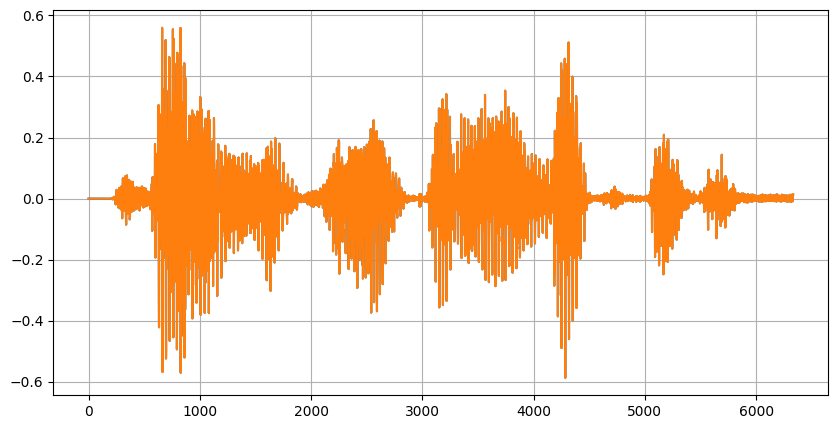

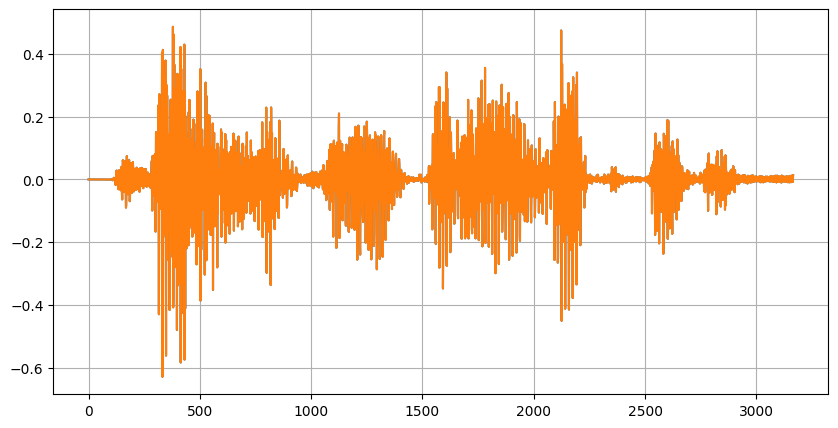

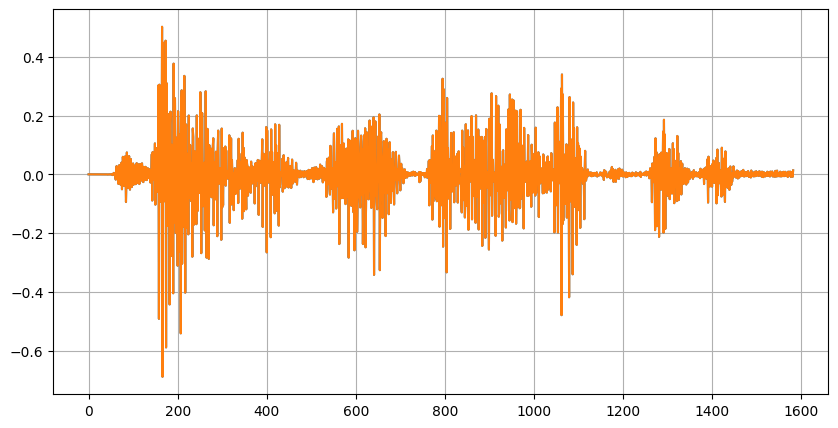

In [18]:
def resample(audio, fq):
    def _resample(old_audio, new_sr, old_samplerate):
        duration = old_audio.shape[0] / old_samplerate
        time_old  = np.linspace(0, duration, old_audio.shape[0])
        time_new  = np.linspace(0, duration, int(old_audio.shape[0] * new_sr / old_samplerate))
        interpolator = sp.interpolate.interp1d(time_old, old_audio.T)
        new_audio = interpolator(time_new).T
    
        return new_audio

    audio_resample = _resample(audio, fq, CD_SR)
    sf.write(f'resources/lab1_voice_{fq}.wav', audio_resample, fq)
    audio_resample, sr = sf.read(f'resources/lab1_voice_{fq}.wav')
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(audio_resample)), audio_resample)
    plt.grid()
    ipd.display(ipd.Audio(audio_resample.T, rate=sr))


[resample(audio_f32, fq) for fq in [22050, 11025, 8000, 4000, 2000, 1000]]

### 3. Чем .wav отличается от других кодеков, например .mp3 или .ogg?

In [ ]:
WAV один из первых кодеков и контейнеров. MP3 разработан в 90х Fraunhofer был проприетарном форматом, одна из ранних свободных ип институтом и его смысл в том чтобы обрезать

# Задание 2. Гармонические сигналы (1 балл)

## Теория
[Гармонические колебания](https://ru.wikipedia.org/wiki/Гармонические_колебания) -  колебания, при которых физическая величина изменяется с течением времени по гармоническому (синусоидальному/косинусоидальному) закону. 

В общем случае гармонические колебания задаются формулой:

$$y=A \cos(\omega t+\varphi_0)$$

где $А$ - это амплитуда, $\omega$ – циклическая частота (радиан/с), $\varphi$ - фаза (сдвиг), $t$ – время. 


In [22]:
# Сначала определим функцию для отрисовки сигнала с хорошим масштабом и сеткой
# Это поможет легче анализировать сигнал
def draw_signal(data, figsize=(14, 14)):
    plt.figure(figsize=figsize)
    plt.plot(data, linewidth=2)
    plt.minorticks_on()
    plt.xticks(np.arange(0, 1000, step=100))
    plt.yticks(np.arange((data.min().round())//10*10, 
                         (data.max().round())//10*10+10, step=5))
    plt.grid(which='major',
        color = 'k', 
        linewidth = 1)
    plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')
    plt.show()

In [39]:
# Читаем данные с подготовленными сигналами
import pickle
with open("resources/data.pickle", "rb") as f:
    test_data = pickle.load(f)
# Теперь можно приступать к практике!
def process(data, X):
    ARRANGE = 1000
    phi = np.arccos(data[0] / X)
    w = 2 * np.pi / (sp.signal.find_peaks(data)[0][1] \
            - sp.signal.find_peaks(data)[0][0])

    x = X * np.cos(w * np.arange(ARRANGE) + np.array([phi] * ARRANGE))
    draw_signal(x)
    print(X, w, phi)

    assert len(x) == 1000
    assert np.allclose(x, data, atol=1)
    print("Ok!")

    return x

## Практика

Постройте графики трех сигналов a, b и c из test_data['task2']. Попробуйте подобрать коэффициенты для этих сигналов. Сгенерируйте сигналы (1000 отсчетов) с подобранными коэффициентами. Постройте графики сгенерированных сигналов и пройдите тест на схожесть с оригинальным.


Подсказка. Фаза, период и амплитуда сигнала - целочисленные. Для генерации пользуйтесь библиотекой numpy и функциями arange, sin, cos.

### Сигнал ***a***

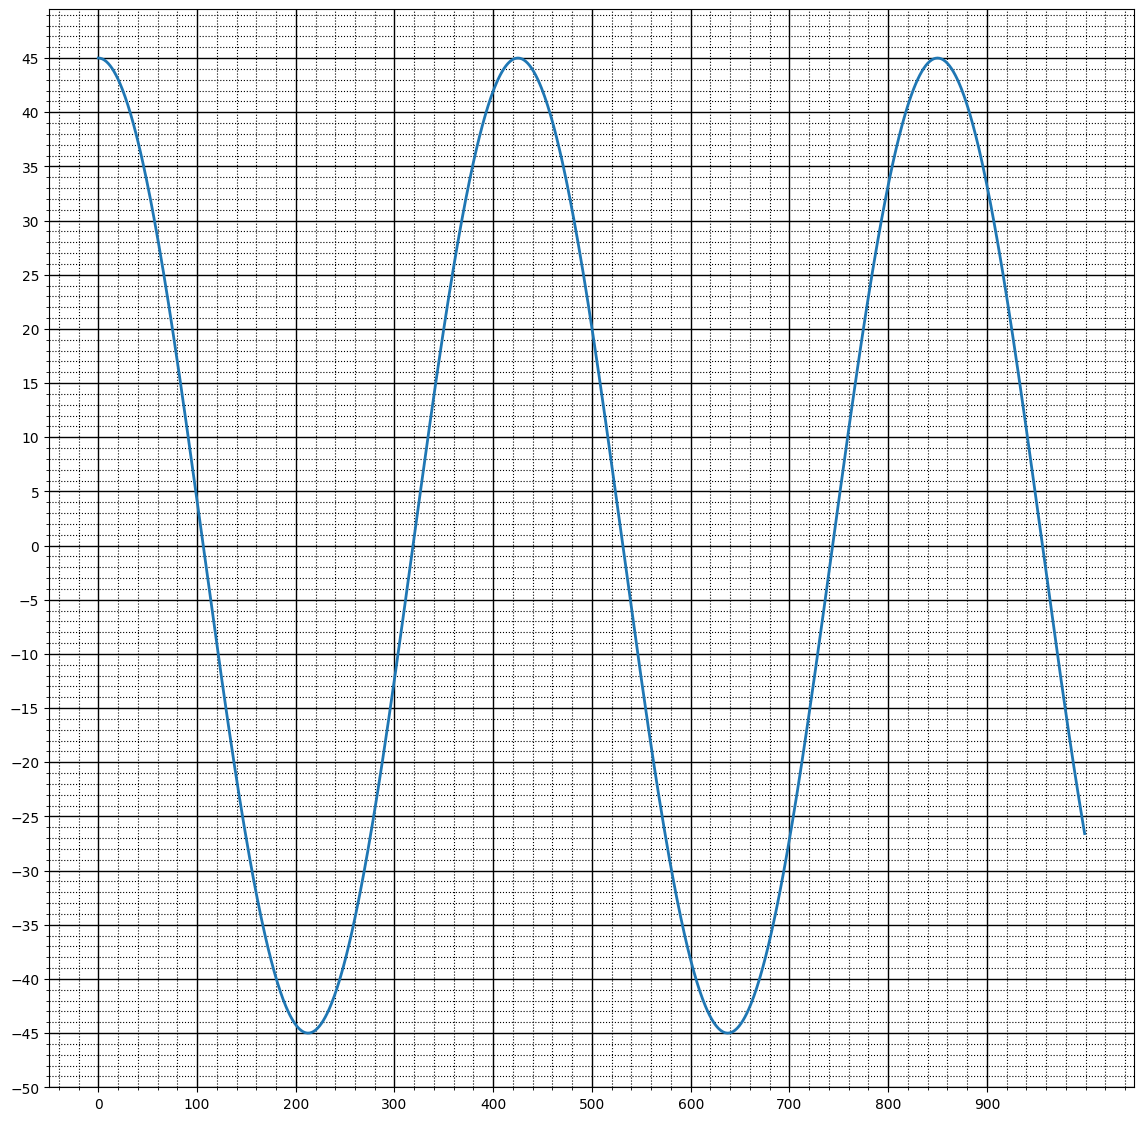

In [30]:
draw_signal(test_data['task2']['a'])

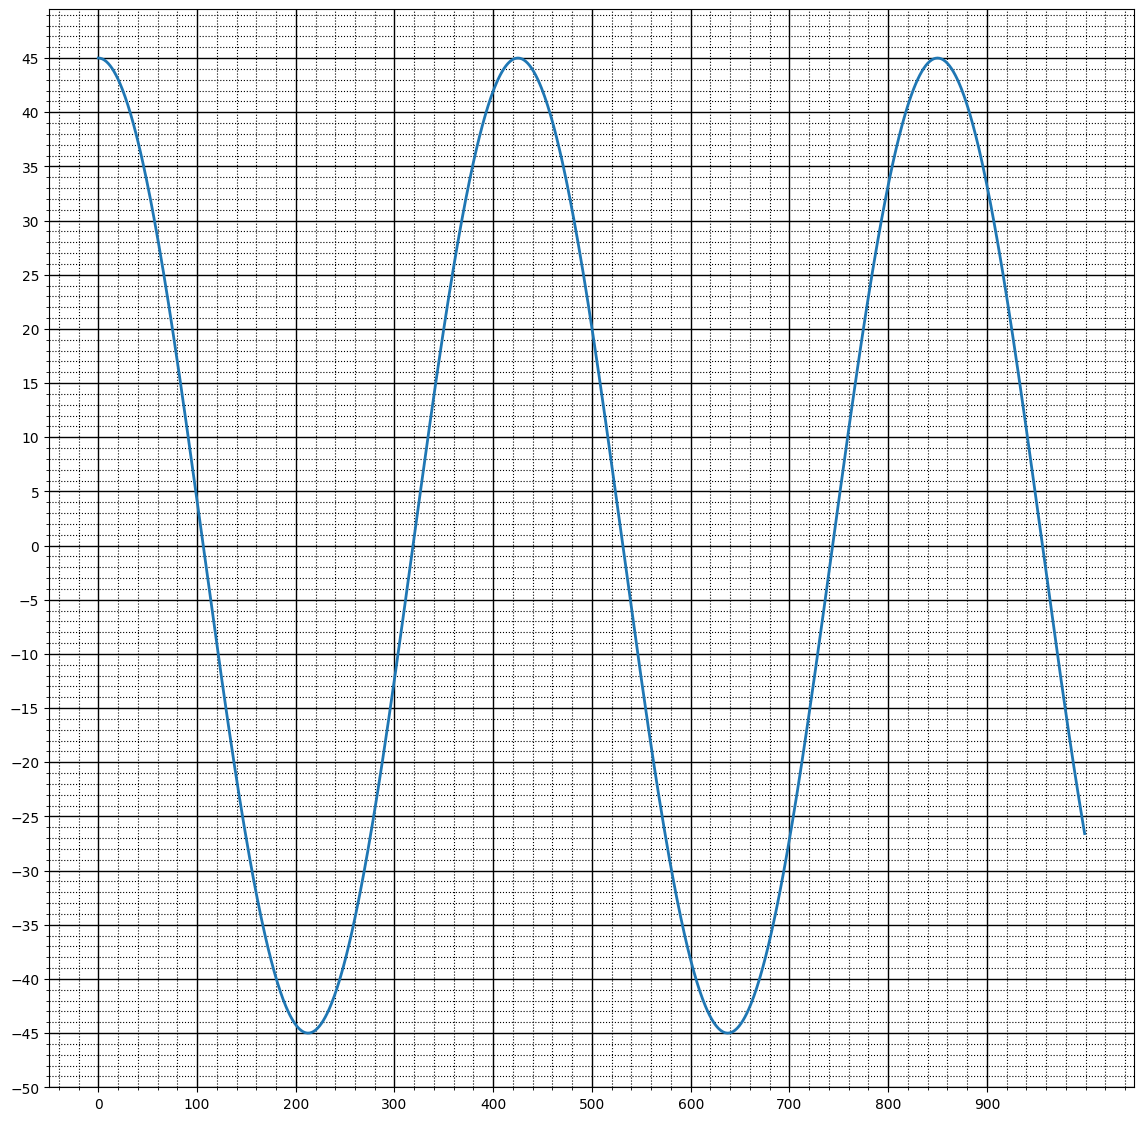

45 0.01478396542865785 0.0
Ok!


In [40]:
a = process(test_data['task2']['a'], 45)

**Подобранные коэффициенты для сигнала 'a':**

1. Амплитуда - $A= $

2. Угловая частота ($ \displaystyle\omega =\frac{2\pi}{T}) = $

3. Фаза - $\phi= $

### Сигнал ***b***

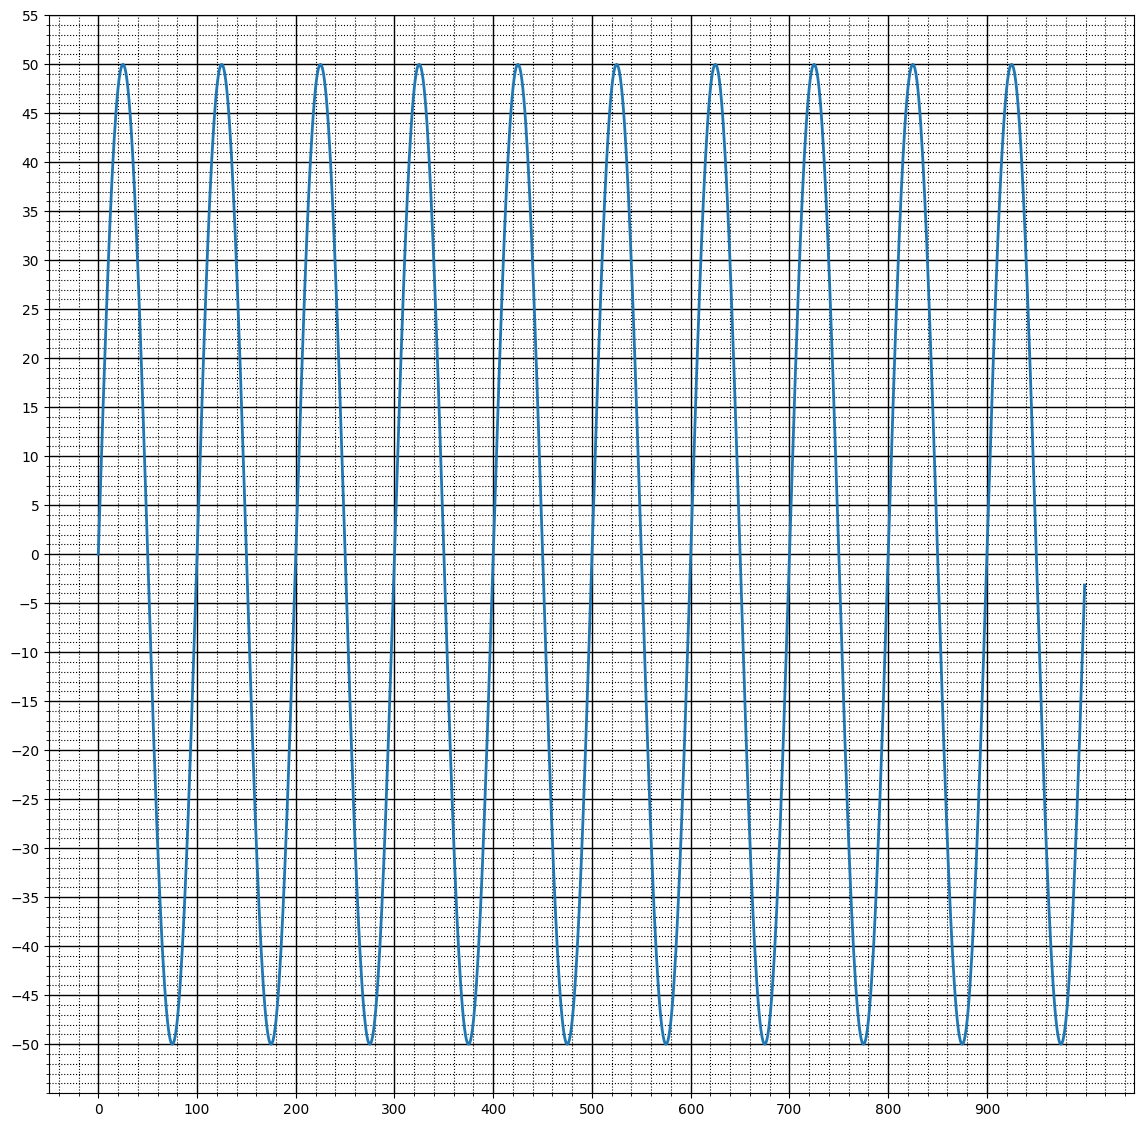

In [45]:
draw_signal(test_data['task2']['b'])

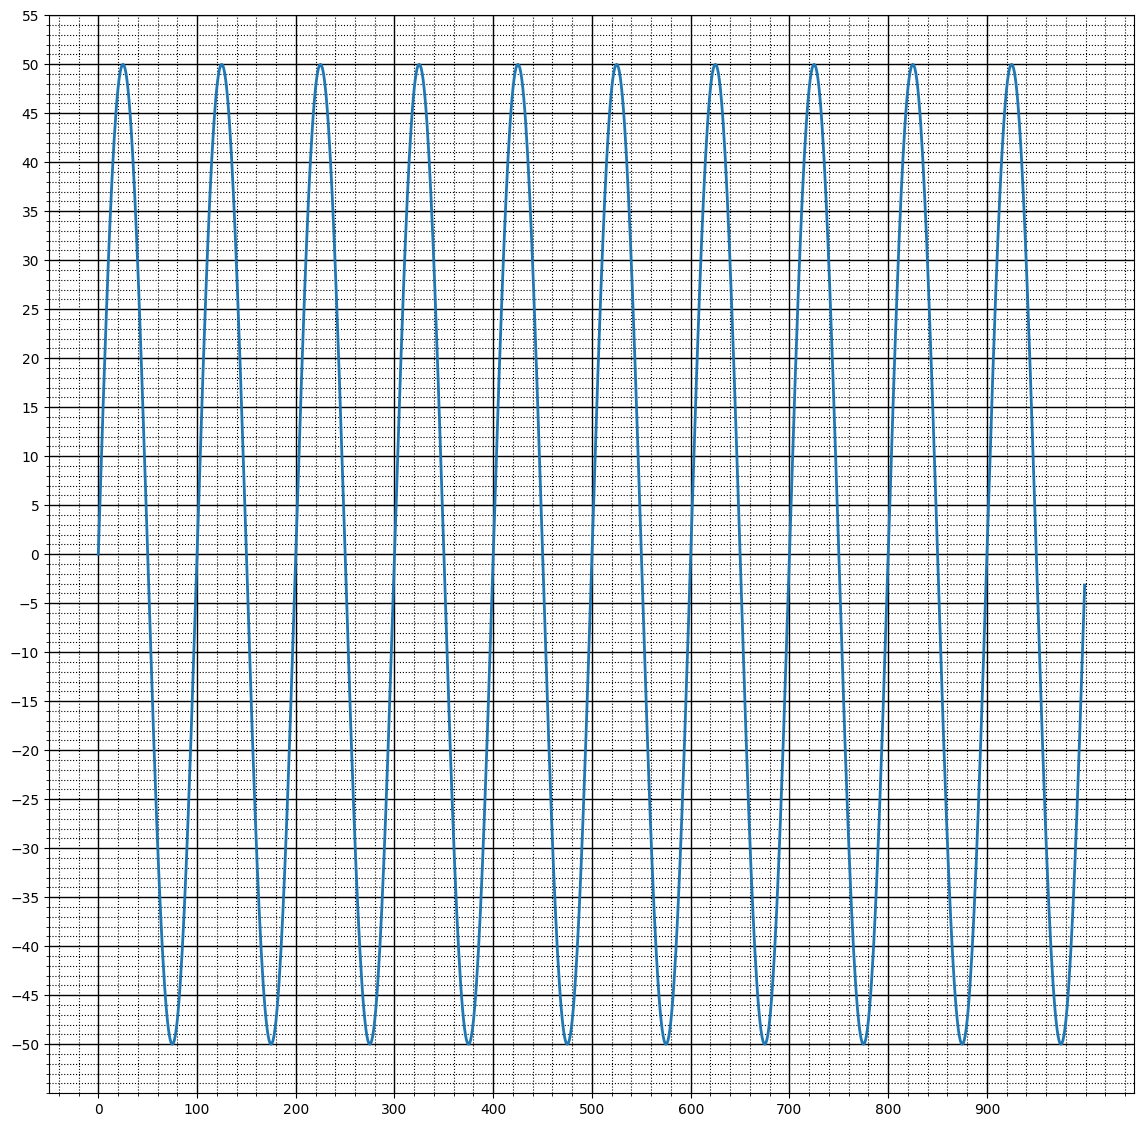

-50 0.06283185307179587 1.5707963267948966
Ok!


In [44]:
b = process(test_data['task2']['b'], -50)

**Подобранные коэффициенты для сигнала 'b':**

1. Амплитуда - $A= $

2. Угловая частота ($ \displaystyle\omega =\frac{2\pi}{T}) = $

3. Фаза - $\phi= $

### Сигнал ***c***

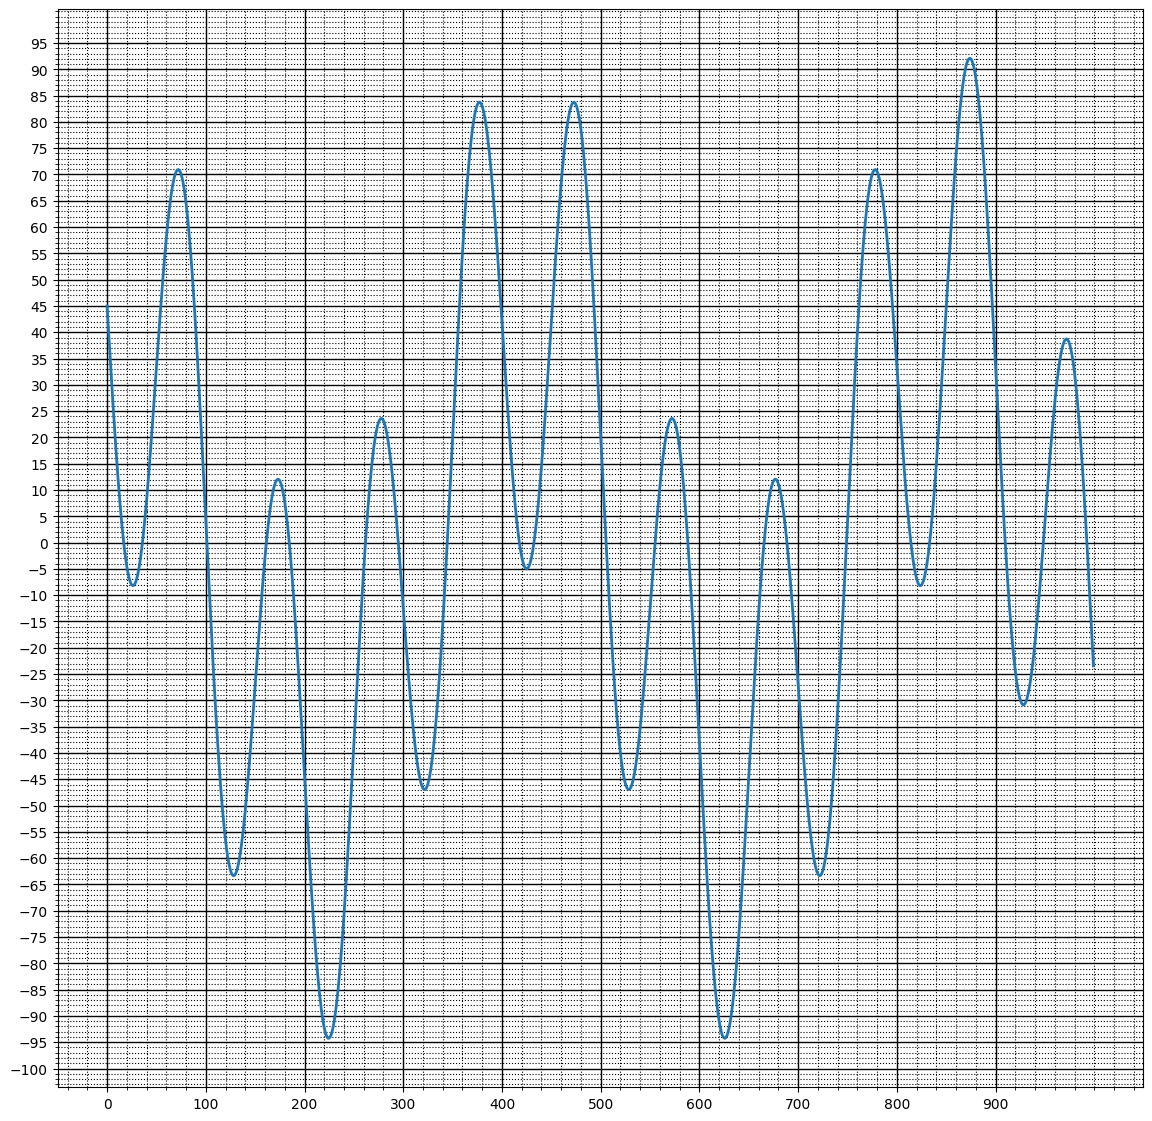

In [46]:
draw_signal(test_data['task2']['c'])

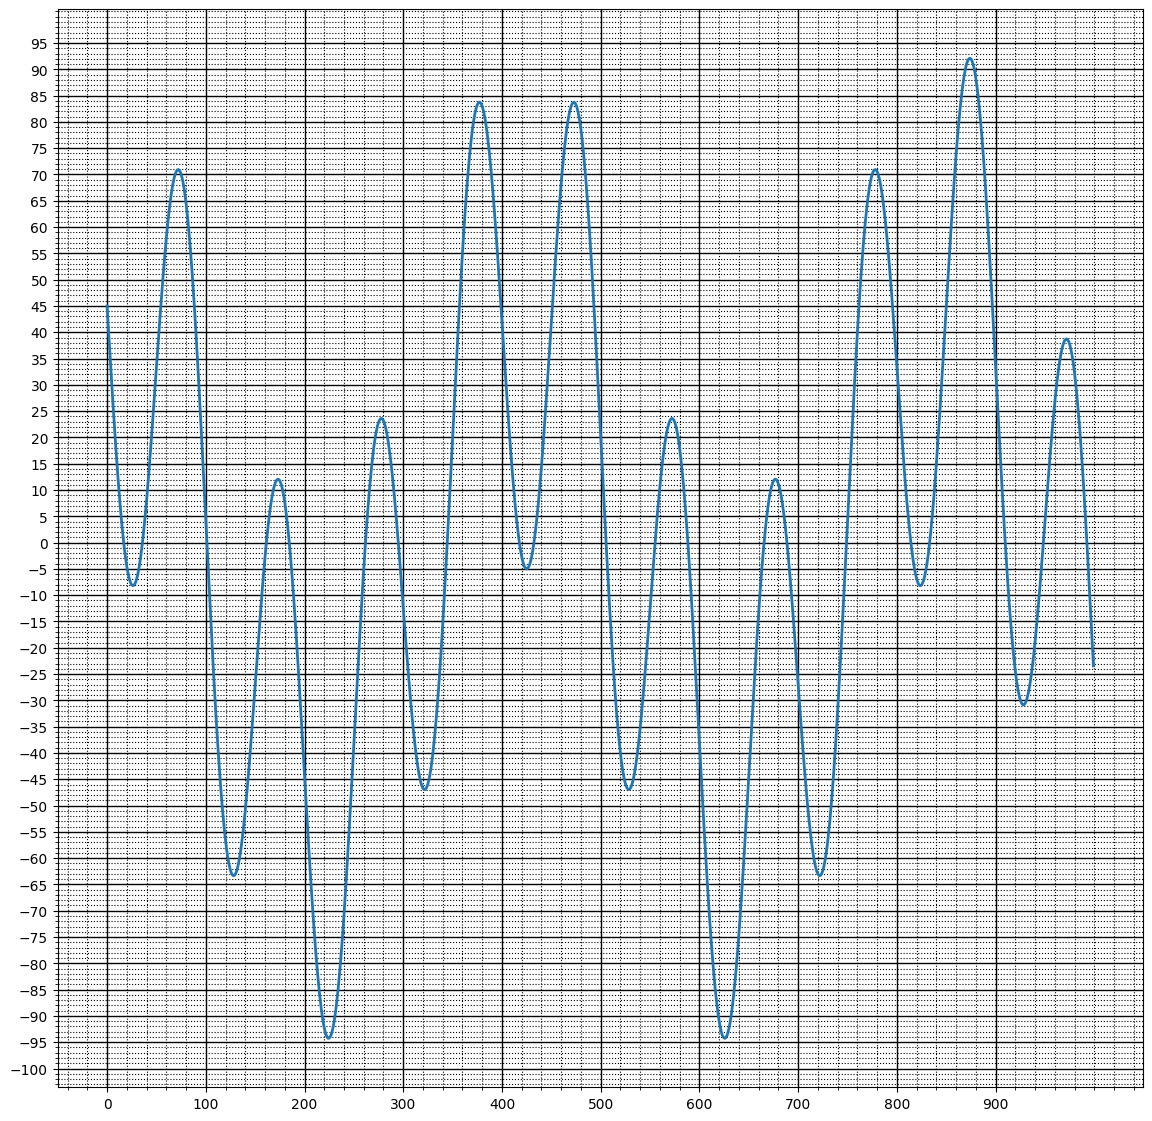

In [49]:
# сигнал состоит из двух гармоник
w = 2 * np.pi / (sp.signal.find_peaks((test_data['task2']['c']))[0][7] \
      - sp.signal.find_peaks((test_data['task2']['c']))[0][1])

c = a - b
draw_signal(c)

In [50]:
assert len(c) == 1000
assert np.allclose(c, test_data["task2"]["c"], atol=1)
print("Ok!")

Ok!


# Задание 3. Свертка (3 балла)

## Теория
Одна из наиболее частых операций, которая выполняется при обработке сигналов, это свёртка. Свёртка имеет много различных применений, например, с ее помощью можно убрать из сигнала шумы или применить к сигналу эффект эхо.


Свёртка — это математическая операция, применённая к двум функциям f и g и порождающая третью функцию. Операцию свёртки можно интерпретировать как «схожесть» одной функции с отражённой и сдвинутой копией другой.  Другими словами, преобразование свёртки однозначно определяет выходной сигнал y(t) для установленного значения входного сигнала x(t) при известном значении функции импульсного отклика системы h(t).

<!-- ![Convolution](resources/Convolution_of_box_signal_with_itself2.gif "Convolution") -->
![Convolution](resources/Convolution_of_box_signal_with_itself2.gif "Convolution")

Формула свёртки:
$$y_t=\frac{1}{2} \int_0^T x(\tau)h(t-τ)dτ$$
где $\tau$  - длительность импульсной переходной характеристики.

## Практика
Реализуйте операцию свёртки. Сравните её с существующей реализацией scipy.signal.convolve. Постройте графики фильтра, исходного сигнала и результата свертки.

In [51]:
def convolve(in1, in2):
    return np.convolve(in1, in2, mode='full')

In [52]:
def test_convolve(a, b, print_debug=False):
    my_result = convolve(a, b)
    scipy_result = scipy.signal.convolve(a, b, method='direct')
    if print_debug:
        print(f"Your result {my_result}")
        print(f"Scipy result {scipy_result}")
    assert np.allclose(my_result, scipy_result), f"Test {a} conv {b} failed"
    print("Ok!")

In [53]:
a = np.repeat([0,1,0], 10)
b = np.array([0,1,2,3,2,1,0])

In [54]:
test_convolve(a, b, print_debug=False)

Ok!


### Нарисуйте результат свертки a и b

Сигнал **а**

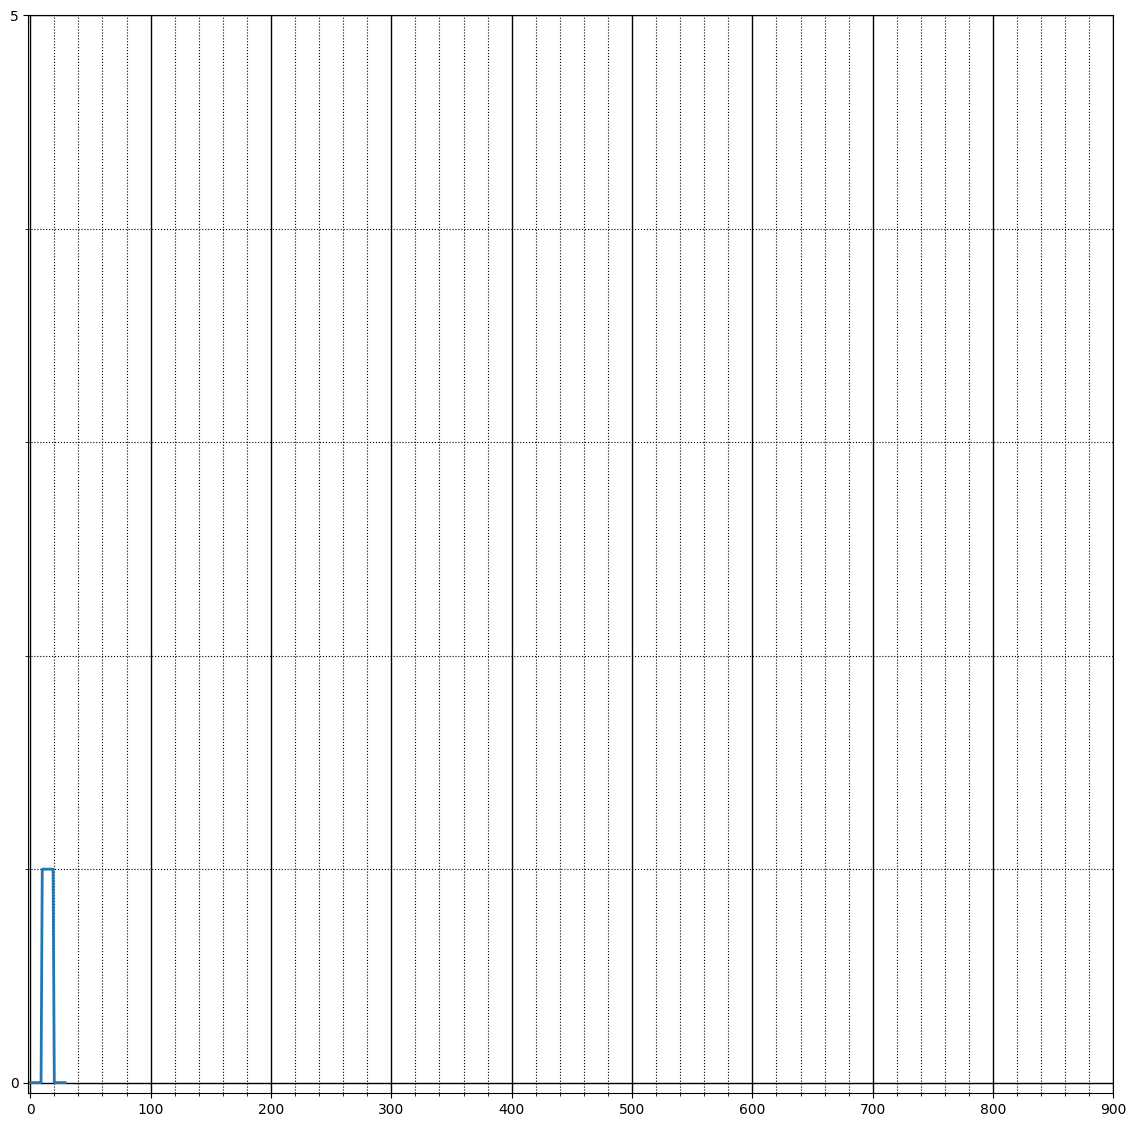

In [55]:
draw_signal(a)

Сигнал **b**

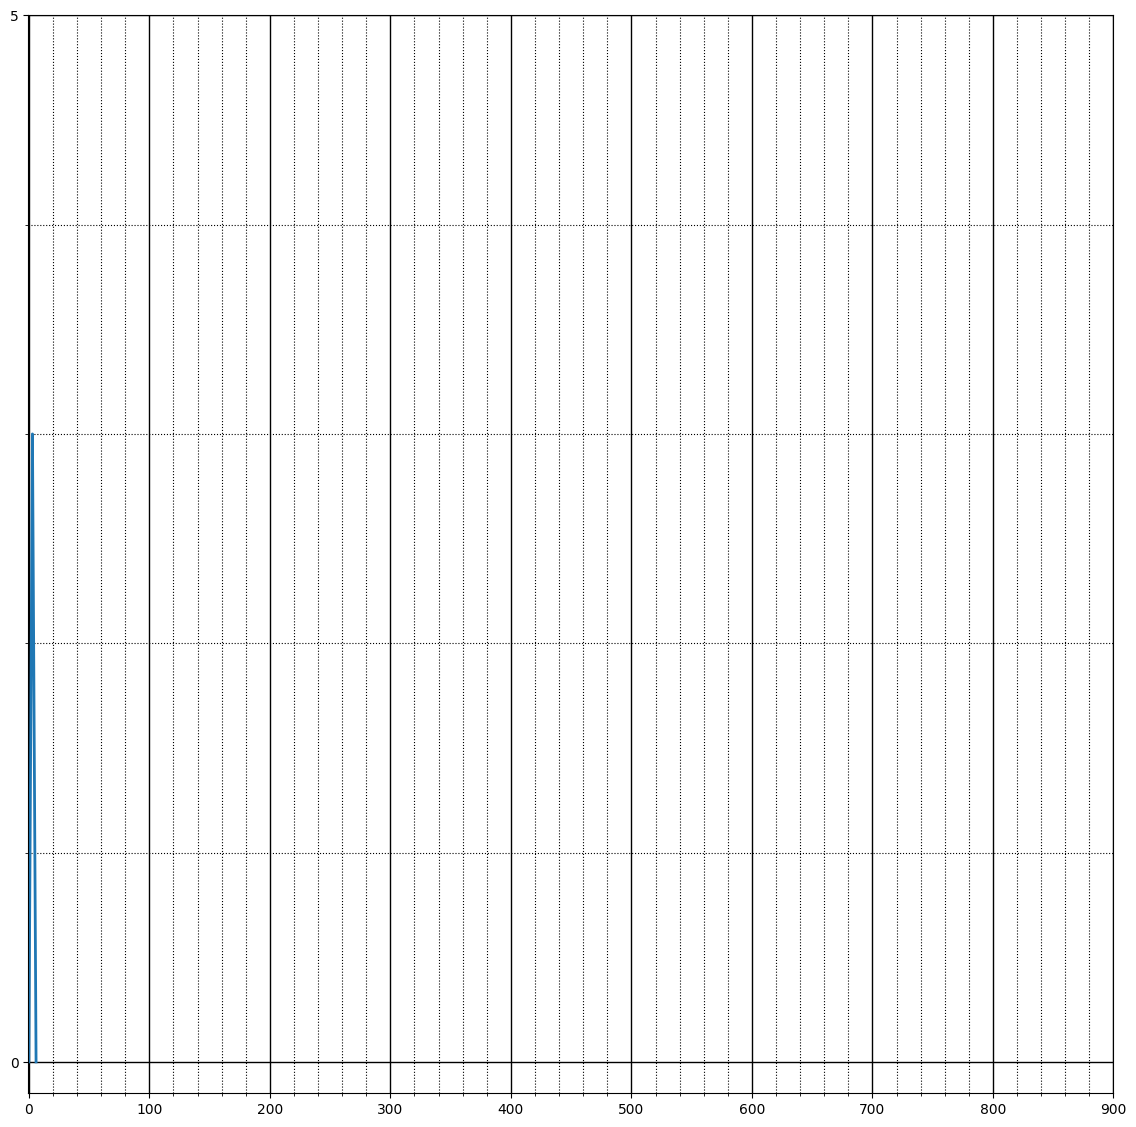

In [56]:
draw_signal(b)

Свертка **a** и **b**

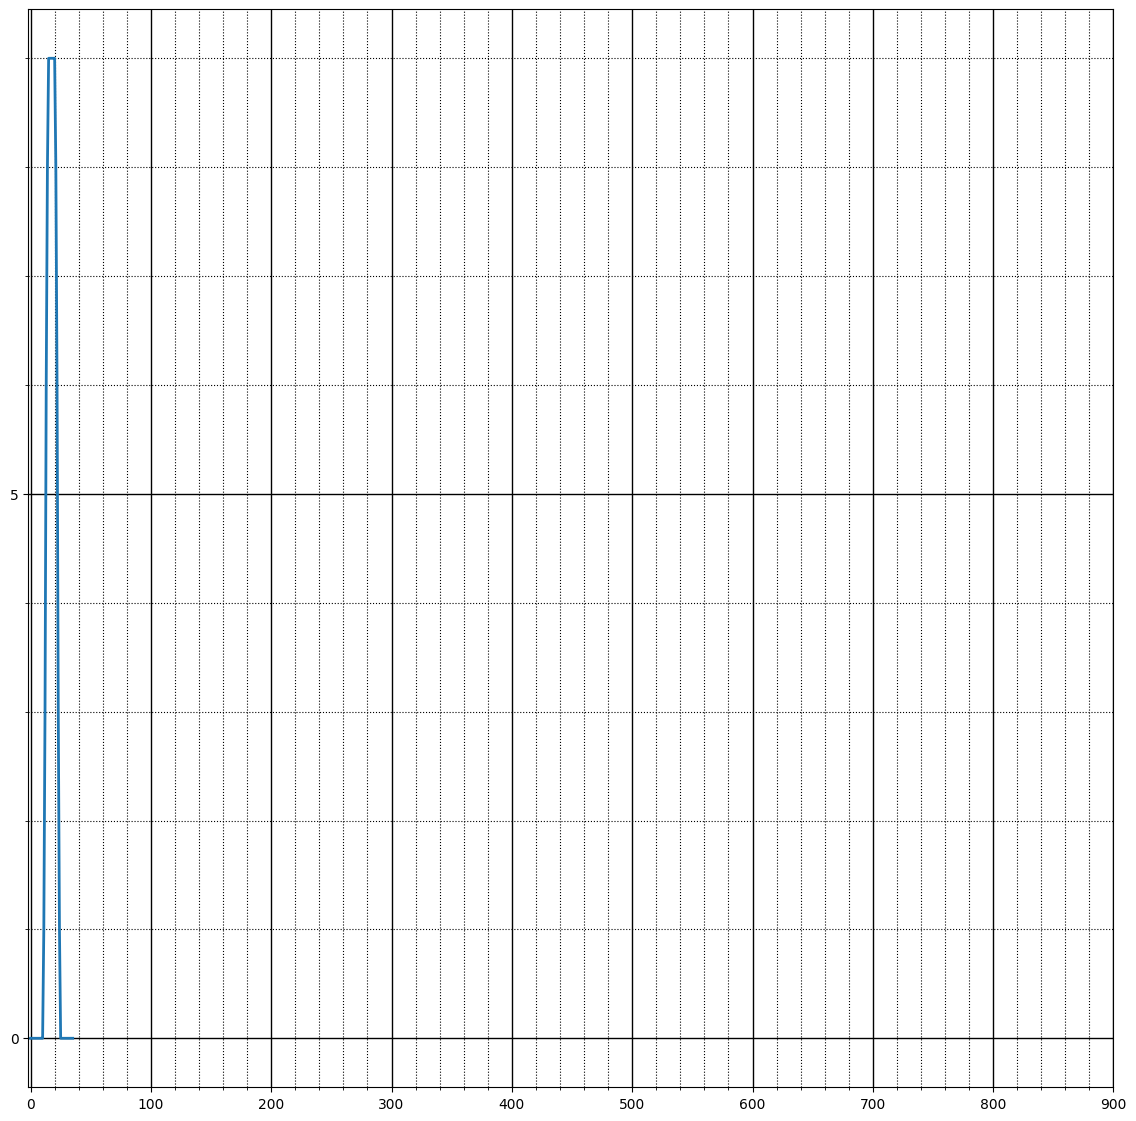

In [58]:
draw_signal(convolve(a, b))

Все 3 графика на одной картинке:

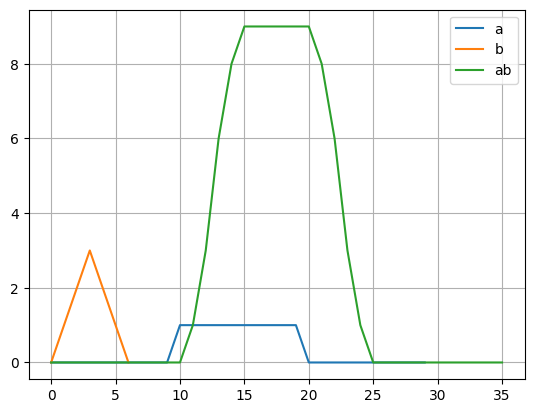

In [59]:
na = len(a)
nb = len(b)
nab = len(convolve(a,b))

xa = np.arange(na)
xb = np.arange(nb)
xab = np.arange(nab)


plt.plot(xa, a, label = 'a')
plt.plot(xb, b, label = 'b')
plt.plot(xab,convolve(a,b), label = 'ab')
plt.legend()
plt.grid()

# Задание 4. * Алгоритм Карплуса-Стронга 

Реализуйте  [Алгоритм Карплуса-Стронга](https://en.wikipedia.org/wiki/Karplus%E2%80%93Strong_string_synthesis). В качестве фильтра используйте усреднитель двух смежных отсчетов. Проверьте результат. 

Отрисуйте и воспроизведите полученный сигнал. На что влияют параметры генерации? Попробуйте имитировать звучание разных струн гитары.

In [60]:
def karplus_strong(noise, N):
    # Noise - input
    # N - number of samples to generate
    # return y - generated signal based on Noise 
    # YOUR CODE HERE
    lenn = len(noise)
    y = np.hstack((noise, np.zeros(N - lenn)))
    for n in range(lenn, N):
        i  = n - lenn
        y[n] = (y[i] + y[i-1]) / 2
    return y

In [61]:
np.random.seed(seed=1)
sample_rate = 44100 
frequency = 82.41
sec = 2
gen_len = sample_rate * sec
noise = (2 * np.random.uniform(-1, 1, int(sample_rate/frequency))) # [-1, 1]

gen_wav = karplus_strong(noise, gen_len)
assert np.allclose(gen_wav[:len(noise)], noise), "Generated signal must starting with noise"
assert np.allclose(gen_wav[len(noise)], (noise[0])/2), "Out of range samples eq 0."
assert np.allclose(gen_wav[len(noise)+1: 2*len(noise)], (noise[:-1] + noise[1:])/2), \
    "Bad requrent rule( 1 iteration)"
assert np.allclose(gen_wav[2*len(noise)], (noise[0]/2 + noise[-1])/2), \
    "Bad requrent rule( 2 iteration)"
assert np.allclose(gen_wav[2*len(noise)+2: 3*len(noise)], \
                   (((noise[:-1] + noise[1:])/2)[:-1] + ((noise[:-1] + noise[1:])/2)[1:])/2), \
    "Bad requrent rule( 3 iteration)"
print('All Ok!')

All Ok!


### Попробуем покрутить параметры генерации

Сгенерируем гитарные ноты:

In [68]:
GFQ = {
    'A': 110.00,
    'D': 146.82,
    'G': 196.00,
    'B': 246.94,
    'E': 329.63,
}

GEN_WAVS = {}

np.random.seed(seed=2)
noise_A = (2 * np.random.uniform(-1, 1, int(sample_rate / GFQ['A'])))
wav_A = karplus_strong(noise_A, gen_len)


np.random.seed(seed=3)
noise_D = (2 * np.random.uniform(-1, 1, int(sample_rate / GFQ['D'])))
GEN_WAVS['D'] = karplus_strong(noise_D, gen_len)


np.random.seed(seed=4)
noise_G = (2 * np.random.uniform(-1, 1, int(sample_rate / GFQ['G'])))
GEN_WAVS['G'] = karplus_strong(noise_G, gen_len)

np.random.seed(seed=5)
noise_B = (2 * np.random.uniform(-1, 1, int(sample_rate / GFQ['B'])))
GEN_WAVS['B'] = karplus_strong(noise_B, gen_len)


np.random.seed(seed=6)
noise_E = (2 * np.random.uniform(-1, 1, int(sample_rate / GFQ['E'])))
GEN_WAVS['E'] = karplus_strong(noise_E, gen_len)

Визуализируем затухание амплитуды:

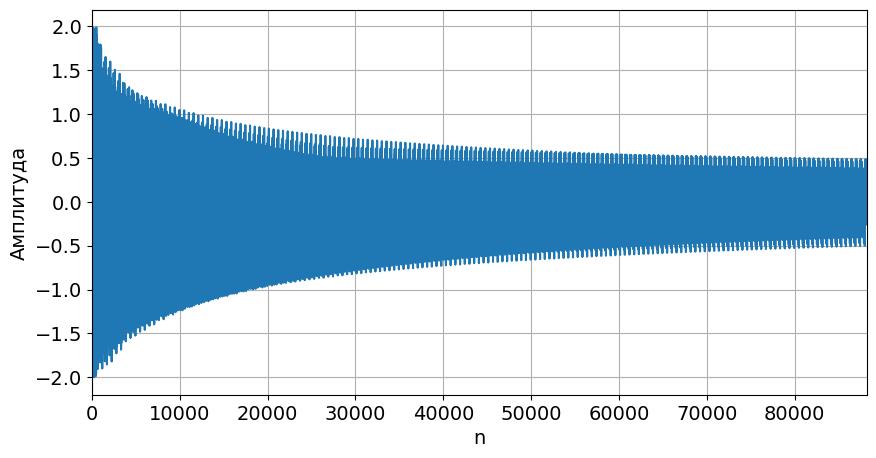

In [69]:
def vis(gen_wavs):
    for gen_wav in gen_wavs:
        plt.figure(figsize=(10,5))
        plt.xlabel('n', fontsize=14)
        plt.ylabel('Амплитуда', fontsize=14)
        plt.xlim(0, gen_len)
        plt.plot(np.linspace(0, gen_len+1, gen_len), gen_wav)
        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.grid()

vis([gen_wav])

Визуализируйте затухание амплитуд гитарных нот:

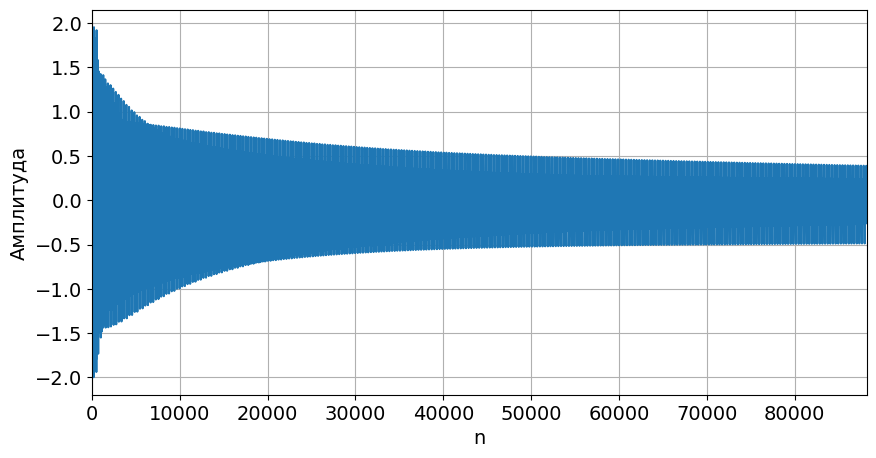

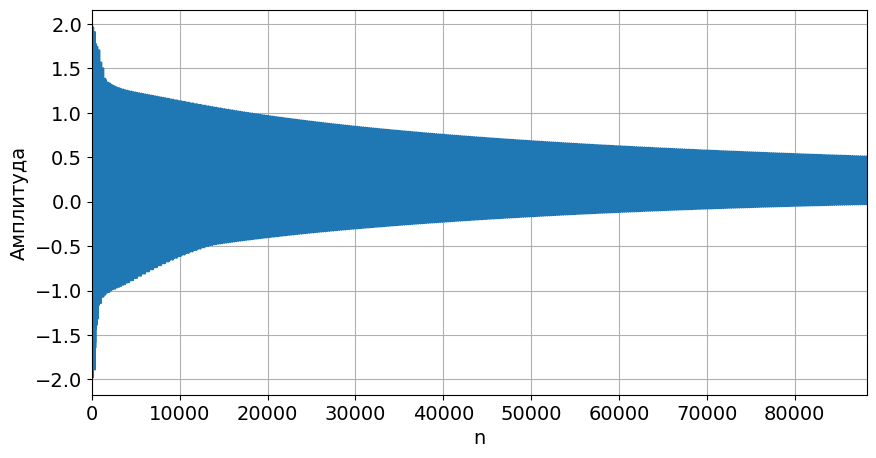

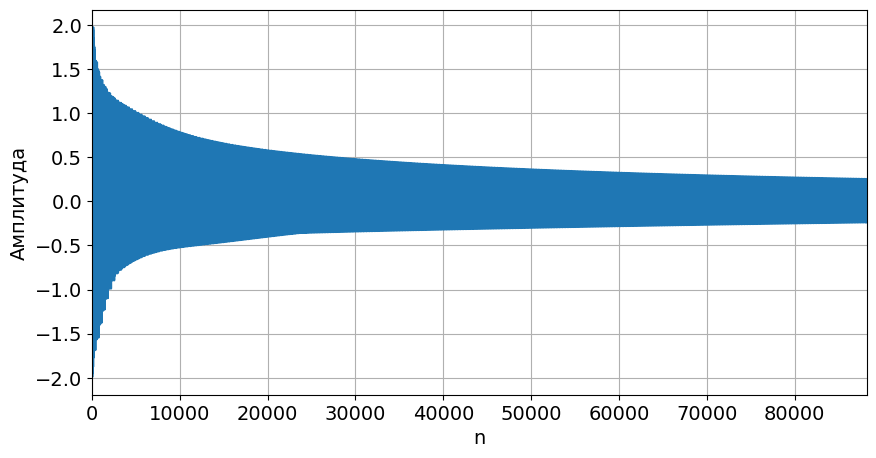

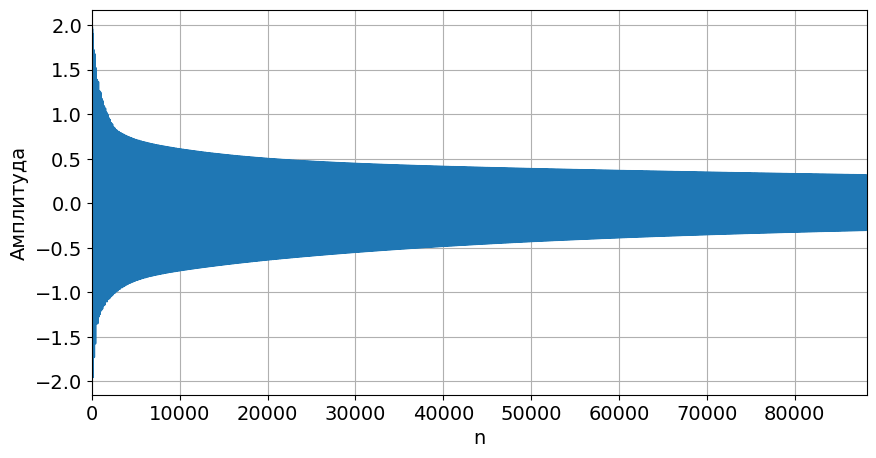

In [70]:
vis(GEN_WAVS.values())